<a href="https://colab.research.google.com/github/Shumin-li-mcit/CIS5300/blob/main/SL_CIS5300_OL_hw6_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6: Neural Language Models

## Due Date: (TBD)
## Total Points: (TBD)
- **Overview**: In this assginment, we’ll be moving on from traditional n-gram based language models to more advanced forms of language modeling using *neural networks*. Specifically, we’ll be setting up a character-level recurrent neural network, known as a char-rnn for short.

  Andrej Karpathy, previously a researcher at OpenAI, has written an excellent blog post about using RNNs for language models, which you should read before beginning this assignment. The title of his blog post is [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

  Karpathy shows how char-rnns can be used to generate texts for several fun domains:

   - Shakespeare plays
   - Essays about economics
   - LaTeX documents
   - Linux source code
   - Baby names

  In this assignment you will follow a PyTorch tutorial to implement your own char-rnn, and then test it on a dataset of your choice. You will also train on our provided training set, and submit to the leaderboard.

- **FAQs:** Please look at the FAQ section before you start working:
  - **How do I save a PyTorch model?**

    Use the command below. Please ensure that your model can be used for inference.
```
torch.save(model.state_dict(), PATH)
```

  - **How do I load a PyTorch model?**

    Use the command below.
```
model = CharRNNClassify()
model.load_state_dict(torch.load(PATH))
model.eval() #To predict
```

  - **I’m unfamiliar with PyTorch. How do I get started?**

    If you are new to the paradigm of computational graphs and functional programming, please have a look at [this tutorial](https://hackernoon.com/linear-regression-in-x-minutes-using-pytorch-8eec49f6a0e2) before getting started.

  - **How do I convert a Jupyter notebook to a python script?**

    Use the command below.
```
jupyter nbconvert --to script notebook.ipynb
```

  - **How do I beat the threshold for the test cases?**

    The TA’s model, which passed all the testcases, had the following configuration:

     - Optimizer: `torch.optim.SGD(model.parameters(), lr=0.005)`
     - Criterion: `nn.NLLLoss()`
     - Iterations: 175k
     - RNN layers: 1 LSTM cell followed by softmax

  - **How do I speed up training?**

    Send the model and the input, output tensors to the GPU using `.to(device)`. Refer [the PyTorch docs](https://pytorch.org/docs/stable/notes/cuda.html) for further information.

  - **Why are some of the cities mislabeled in the training and development datasets?**

    Noisy data is common when data is harvested automatically like [the cities dataset](https://www.maxmind.com/en/geoip-demo). The onus is on the data scientist to ensure that their data is clean. However, for this assignment, you are not required to clean the dataset.

- **Please include the following in your report**:

  For Section 1:
  - A description of what you tried, and the final model you settled on
  - A table with validation results for the models you tried
  - A plot of validation accuracy as your best model is training
  - An error analysis, including a confusion matrix and a dicussion of what is happening.

  For Section 2:
  - A description of the text you are training on
  - A description of the model you are running
  - A table of example generations
  - Perplexity results on two types of held out data: (a) similar to what you trained on and (b) dissimilar to what you trained on
  - A comparison of your model’s behavior to an n-gram language model.

- **Grading**: We will use the auto-grading system called `PennGrader`. To complete the homework assignment, you should implement anything marked with `#TODO` and run the cell with `#PennGrader` note. **There will be no hidden tests in this assignment.** In other words, you will know your score once you finish all the `#TODO` and run all the `#PennGrader` tests!


## Recommended Readings
- [Neural Nets and Neural Language Models](https://web.stanford.edu/~jurafsky/slp3/8.pdf). Dan Jurafsky and James H. Martin. Speech and Language Processing (3rd edition draft) .
- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Andrej Karpathy. Blog post. 2015.
- [A Neural Probabilistic Language Model (longer JMLR version)](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). Yoshua Bengio, Réjean Ducharme, Pascal Vincent and Christian Jauvin. Journal of Machine Learning Research 2003.

## To get started, **make a copy** of this colab notebook into your google drive!

## Setup 1: PennGrader Setup

In [1]:
## DO NOT CHANGE ANYTHING, JUST RUN
%%capture
!pip install penngrader-client

In [2]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [3]:
!cat notebook-config.yaml


grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'


In [4]:
from penngrader.grader import *

## TODO - Start
STUDENT_ID = 65847590 # YOUR PENN-ID GOES HERE AS AN INTEGER#
## TODO - End

SECRET = STUDENT_ID
grader = PennGrader('notebook-config.yaml', 'CIS5300_OL_23Su_HW6', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 65847590

Make sure this correct or we will not be able to store your grade


In [5]:
# check if the PennGrader is set up correctly
# do not chance this cell, see if you get 4/4!
name_str = 'Shumin Li'
grader.grade(test_case_id = 'name_test', answer = name_str)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Setup 2: Dataset / Packages
- **Run the following cells without changing anything!**

In [6]:
#Import Packages
from os.path import exists
from sklearn.metrics import accuracy_score
import codecs
import math
import random
import string
import time
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import torch
import torch.nn.functional as F

from io import open
import glob
import os
import unicodedata

In [7]:

#Download and unzip files
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
!sudo apt-get install unzip
!unzip cities_val.zip
!unzip cities_train.zip

--2023-06-28 20:11:27--  http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
Resolving computational-linguistics-class.org (computational-linguistics-class.org)... 185.199.110.153
Connecting to computational-linguistics-class.org (computational-linguistics-class.org)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10973 (11K) [text/plain]
Saving to: ‘cities_test.txt’

cities_test.txt     100%[===================>]  10.72K  --.-KB/s    in 0s      

2023-06-28 20:11:28 (110 MB/s) - ‘cities_test.txt’ saved [10973/10973]

--2023-06-28 20:11:28--  http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
Resolving computational-linguistics-class.org (computational-linguistics-class.org)... 185.199.110.153
Connecting to computational-linguistics-class.org (computational-linguistics-class.org)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7558 (7.4K) [application/zip]
Sav

##**About PyTorch**


PyTorch is one of the most popular deep learning frameworks in both industry and academia, and learning its use will be invaluable should you choose a career in deep learning. You will be using PyTorch for this assignment, we ask you to build off a couple PyTorch tutorials.

PyTorch abstracts the back-propogation process from us, allowing us to define neural network structures and use a generic `.backward()` function to compute the gradients that are later used in gradient descent (PyTorch also implements such optimization algorithms for us).

<img src='https://drive.google.com/uc?id=15pO4cDL_F_AKaJhTTAexAny--faAFp5q'>

PyTorch does all of this for us by maintaining a computational graph, which allows differentiation to happen automatically! Don’t worry if you don’t remember your chain rules from MATH 114. Another nice thing about PyTorch is that it makes strong use of both object-oriented and functional programming paradigms, which makes reading and writing PyTorch code very accessible to previous programmers.

Before you start, make sure you have run the previous cells to set up the environment. Remember to set hardware accelerator to **GPU** under **Change Runtime Type** in the **Runtime** menu.


In [8]:
#Verfiy file download
!head train/af.txt
!printf "\n"
!head val/af.txt
!printf "\n"
!head cities_test.txt
!printf "\n"

garavshakh
kalishli
sarban kelay
dahan-e surunah
jahannum
morafeno
iskatel
zeri-chinar
taftebole
dzhafarabat

sikhtopa
laferronay
cham ghafur
souk tafetecht
panqash
siah sar bala
barah khan kili
vetob
kacari
kolga'i-i-bala

imam bakhsh amar
firoz laghari
glufishevo
qal`eh-ye ghazanfarkhani
nikolinalevada
kolkko
mbrostar i fierit
kharabanan-e sofla
stein bei nurnberg
jahangir bara



In [9]:
#Verify CUDA acceleration, should print cuda:0
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Section 1: Character-Level Recurrent Neural Networks



##**Follow the tutorial code**

Read through the tutorial [here](http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) that builds a char-rnn that is used to classify baby names by their country of origin. It is recommended that you can reproduce the tutorial’s results on the provided name dataset before moving on, since the neural network architectures remain largely the same. Make sure you try your best to understand the dimensions of each layer (e.g. which ones can stay the same, and which are hyperparameters for us to tweak).




##**Switch to city names dataset**

Modify the tutorial code and implement the functions below to instead read from the city names dataset that we used in the previous assignment. The tutorial code problematically used the same text file for both training and evaluation. We learned in class about how this is not a great idea. For the city names dataset we provide you separate train and validation sets, as well as a test file for the leaderboard.

All training should be done on the train set and all evaluation (including confusion matrices and accuracy reports) on the validation set. You will need to change the data processing code to get this working. In addition, to handle unicode, you might need to replace calls to `open` with calls to `codecs.open(filename, "r",encoding='utf-8', errors='ignore')`.

**Warning**: you’ll want to lower the learning rating to 0.002 or less or you might get NaNs when training.

In [10]:
'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)

57


### **Task 1.1**: Implement the functions below to read data

In [11]:
# Build the category_lines dictionary, a list of city names per language
category_lines_train = {}
category_lines_val = {}
all_categories = []

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)

# Read a file and split into lines
def readLines(filename):
  fd = codecs.open(filename, "r", encoding='utf-8', errors='ignore')
  lines = fd.read().strip().split('\n')
  return [line for line in lines]

# record the number of training lines
num_tot_train = 0
for filename in findFiles('train/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    num_tot_train += len(lines)
    category_lines_train[category] = lines
n_categories = len(all_categories)
all_categories = sorted(all_categories)


global num_tot_val
num_tot_val = 0
for filename in findFiles('val/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    lines = readLines(filename)
    category_lines_val[category] = lines
    num_tot_val += len(lines)


In [12]:
'''
Returns the words of the language specified by reading it from the data folder
Returns the validation data if train is false and the train data otherwise.
Return: A n*1 numpy array containing the words of the specified language
'''
def getWords(lang, train = True):
    # TODO
    if train:
      words = category_lines_train[lang]
      lang_words = np.empty(len(words), dtype = object)
      for i in range(len(words)):
        lang_words[i] = words[i]
    else:
      words = category_lines_val[lang]
      lang_words = np.empty(len(words), dtype = object)
      for i in range(len(words)):
        lang_words[i] = words[i]
    return lang_words

In [13]:
all_categories

['af', 'cn', 'de', 'fi', 'fr', 'in', 'ir', 'pk', 'za']

In [14]:
'''
Returns a label corresponding to the language
For example: it returns an array of 0s for af
Return: A n*1 numpy array as integers containing index of the specified language in the "languages" array
'''
def getLabels(lang, length):
  srt_cat = sorted(all_categories)
  idx = srt_cat.index(lang)
  arr = np.full(length, idx)
  return arr

In [15]:
'''
Returns all the laguages and labels after reading it from the file
Returns the validation data if train is false and the train data otherwise.
You may assume that the files exist in baseDir and have the same names.
Return: X, y where X is a n*1 numpy array with data and y is a n*1 numpy array with labels
'''
def readData(train=True):
  X = getWords(all_categories[0], train = train)
  y = getLabels(all_categories[0], X.shape[0])
  for i in range(1, n_categories):
    x = getWords(all_categories[i], train = train)
    X = np.concatenate((X, x))
    y = np.concatenate((y, getLabels(all_categories[i], x.shape[0])))
  return X, y


In [16]:
# TODO: Read train dataset here
trainData = readData(train=True)

In [17]:
trainData[0].shape

(27000,)

In [18]:
# PennGrader - DO NOT CHANGE
grader.grade(test_case_id = 'testReadData', answer = (trainData[0][:50], trainData[1]))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **Task 1.2**: Implement the functions for data pre-processing

In [19]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

'''
Convert a line/word to a pytorch tensor of numbers
Refer the tutorial in the spec
Return: A tensor corresponding to the given line
'''
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [20]:
# PennGrader - DO NOT CHANGE
test_tensor = line_to_tensor("test_word").numpy()
grader.grade(test_case_id = 'testLineToTensor', answer = test_tensor)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [21]:
'''
Returns the category/class of the output from the neural network
Input: Output of the neural networks (class probabilities) as a tensor
Return: A tuple (language, language_index)
        language: "af", "cn", etc.
        language_index: 0, 1, etc.
'''
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [22]:
import random

'''
Get a random input output pair to be used for training
Refer the tutorial in the spec
Input: training data (X, y)
Return: A tuple of 4 items: category, line, category_tensor, line_tensor
'''
def random_training_pair(X, y):
  idx = random.randint(0, len(X)-1)
  line = X[idx]
  line_tensor = line_to_tensor(line)
  category = all_categories[y[idx]]
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  return category, line, category_tensor, line_tensor

### **Task 1.3**: Implement functions for model training

In [23]:
# Just return an output given a line
def evaluate(model, line_tensor):
  hidden = model.init_hidden()
  for i in range(line_tensor.size()[0]):
      output, hidden = model(line_tensor[i], hidden)
  return output, hidden

'''
Input: trained model, a list of words X
Output: a list of predicted class labels as integers
'''
def predict(model, X):
  line_tensors = [line_to_tensor(line) for line in X]
  outputs = [evaluate(model, line_tensor) for line_tensor in line_tensors]
  tuple_lst = [category_from_output(output) for output, hidden in outputs]
  labels = [guess_i for guess, guess_i in tuple_lst]
  return labels

'''
Input: trained model, a list of words X, a list of class labels as integers y
Return: average validation loss
'''
def val_losses(model, criterion, X, y):
  val_losses = []
  line_tensors = [line_to_tensor(line) for line in X]
  for i in range(len(y)):
    output, _ = evaluate(model, line_tensors[i])
    category = all_categories[y[i]]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    loss = criterion(output, category_tensor)
    val_losses.append(loss.item())
  avg_loss = sum(val_losses)/len(val_losses)
  return avg_loss

In [24]:
'''
Input: trained model, a list of words, a list of class labels as integers
Output: The accuracy of the given model on the given input X and target y
'''
def calculateAccuracy(model, X, y):
  y_predict = predict(model, X)
  matches = [i for i, j in zip(y_predict, y) if i == j]
  accuracy = len(matches)/len(y) # round into two decimal places for consistency
  # print(f'match {len(matches)}; totoal {len(y)}; accuracy {accuracy}')
  return accuracy

In [25]:
'''
Train the model for one epoch/one training word with random_training_pair().
Ensure that it runs within 3 seconds.
Input: X and y are lists of words as strings and classes as integers respectively
Returns: You may return anything
'''
def trainOneEpoch(model, criterion, optimizer, X, y):
    hidden = model.init_hidden()
    optimizer.zero_grad()
    category, line, category_tensor, line_tensor = random_training_pair(X, y)
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return category, output, loss.item()

### **Task 1.4**: Train your model

In [26]:
# 2 linear layers
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
      super(CharRNNClassify, self).__init__()
      self.hidden_size = hidden_size
      self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
      self.h2o = nn.Linear(hidden_size, output_size)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
      combined = torch.cat((input, hidden), 1)
      hidden = self.i2h(combined)
      output = self.h2o(hidden)
      output = self.softmax(output)
      return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [32]:
# RNN + linear layer
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNNClassify, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.rnn1 = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = self.num_layers, batch_first = True)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
      output, hidden = self.rnn1(input, hidden)
      output = self.h2o(output.view(-1, self.hidden_size))
      output = self.softmax(output)
      return output, hidden

    def init_hidden(self):
        return torch.zeros(self.num_layers, self.hidden_size)

In [85]:
# LSTM + linear layer
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNNClassify, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers = self.num_layers, batch_first = True) #lstm
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.h2o(output.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        h_0 = Variable(torch.zeros(1, self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(1, self.hidden_size)) #internal state
        return h_0, c_0

In [75]:
# LSTM + multiple linear layer + dropout
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNNClassify, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers = self.num_layers, batch_first = True) #lstm
        # self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers = self.num_layers, batch_first = True)
        self.dropout = nn.Dropout(0.1)
        self.h2h = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.h2o = nn.Linear(128, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        drop = self.dropout(output)
        output = self.h2h(drop.view(-1, self.hidden_size)) # first linear
        output = self.relu(output) # for the model to better learn non-linear functions
        output = self.h2o(output) # second linear
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        h_0 = Variable(torch.zeros(1, self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(1, self.hidden_size)) #internal state
        return h_0, c_0

In [27]:
# bidrectional lstm + linear layer + dropout
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNNClassify, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers = self.num_layers, batch_first = True, bidirectional=True) #lstm
        # self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers = self.num_layers, batch_first = True)
        # self.dropout = nn.Dropout(0.1)
        self.h2o = nn.Linear(hidden_size*2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        # drop = self.dropout(output)
        output = self.h2o(output.view(-1, self.hidden_size*2))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        h_0 = Variable(torch.zeros(2, self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(2, self.hidden_size)) #internal state
        return h_0, c_0

In [66]:
# GRU + linear layer
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNNClassify, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.gru= nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers = self.num_layers, batch_first = True) #lstm
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = self.h2o(output.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        h_0 = Variable(torch.zeros(1, self.hidden_size)) #hidden state
        return h_0

In [ ]:
device = torch.device("cuda")

In [26]:
n_hidden = 128
output_size = n_categories
input_size = n_letters
test_model = CharRNNClassify(input_size, n_hidden, output_size)

category, output, loss = trainOneEpoch(test_model,nn.NLLLoss(),
                torch.optim.SGD(test_model.parameters(), lr=0.005),
                trainData[0], trainData[1])
guess, guess_i = category_from_output(output)
print(guess)
print(category)


ir
af


In [45]:
import time
import math
import matplotlib.pyplot as plt

trainData = readData(train=True)
valData = readData(train=False)
output_size = n_categories
input_size = n_letters

print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

'''
Use this to train and save your classification model.
Save your model with the filename "model_classify"
Consider printing out some stats to track training progress
Record training loss and validation loss for analysis
You may return anything
'''
def run(n_hidden=128, lr=0.005, n_iters=100000, train=trainData, val=valData):
  model = CharRNNClassify(input_size, n_hidden, output_size)
  start = time.time()

  # Keep track of losses for plotting
  cur_train_loss = 0
  all_train_losses = []

  all_val_losses = []

  acc_ct = 0
  all_acc = []

  for iter in range(1, n_iters + 1):
      category, output, train_loss = trainOneEpoch(model, nn.NLLLoss(),
                torch.optim.SGD(model.parameters(), lr=lr),
                trainData[0], trainData[1])
      cur_train_loss += train_loss
      guess, guess_i = category_from_output(output)
      if guess == category:
          correct = '✓'
          acc_ct += 1
      else:
          correct = '✗ (%s)' % category

      # Add current loss avg to list of losses and accuracy scores
      if iter % plot_every == 0:
          all_train_losses.append(cur_train_loss / plot_every)
          cur_train_loss = 0
          all_acc.append(acc_ct / plot_every)
          acc_ct = 0
      '''
      if iter % val_every == 0:
          val_loss = val_losses(model, nn.NLLLoss(), valData[0], valData[1])
          all_val_losses.append(val_loss)
      '''


      # Print ``iter`` number, loss, accuracy, guess and correct category
      if iter % print_every == 0:
        print('%d %d%% (%s) t_loss: %.4f t_acc: %.4f %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss, all_acc[-1], guess, correct))

  model_name = 'bLSTM_model_classify_' + str(n_hidden) + '_' + str(lr) + '_' + str(n_iters)
  torch.save(model.state_dict(), model_name)

  return all_train_losses

In [46]:
# LSTM + linear
all_train_losses = run(n_hidden=128, lr=0.1, n_iters=300000)

5000 1% (1m 27s) t_loss: 1.2707 t_acc: 0.2840 de ✗ (fr)
10000 3% (3m 0s) t_loss: 0.6622 t_acc: 0.3840 in ✓
15000 5% (4m 32s) t_loss: 4.7457 t_acc: 0.4560 af ✗ (fi)
20000 6% (5m 57s) t_loss: 4.6470 t_acc: 0.5610 in ✗ (af)
25000 8% (7m 22s) t_loss: 1.1384 t_acc: 0.6090 ir ✗ (za)
30000 10% (8m 48s) t_loss: 0.4907 t_acc: 0.6140 af ✓
35000 11% (10m 13s) t_loss: 0.0331 t_acc: 0.6550 cn ✓
40000 13% (11m 36s) t_loss: 0.0539 t_acc: 0.6900 fi ✓
45000 15% (13m 2s) t_loss: 0.5406 t_acc: 0.6810 fi ✓
50000 16% (14m 28s) t_loss: 0.1301 t_acc: 0.6700 de ✓
55000 18% (15m 56s) t_loss: 0.9089 t_acc: 0.6780 af ✓
60000 20% (17m 20s) t_loss: 1.6497 t_acc: 0.6990 af ✗ (ir)
65000 21% (18m 45s) t_loss: 0.4091 t_acc: 0.7080 za ✓
70000 23% (20m 9s) t_loss: 2.9893 t_acc: 0.7350 af ✗ (za)
75000 25% (21m 35s) t_loss: 0.0384 t_acc: 0.7230 ir ✓
80000 26% (23m 0s) t_loss: 2.1858 t_acc: 0.7290 cn ✗ (pk)
85000 28% (24m 25s) t_loss: 0.3025 t_acc: 0.7170 fr ✓
90000 30% (25m 48s) t_loss: 0.9353 t_acc: 0.7350 fr ✗ (za)
9500

In [37]:
lrs = [0.003, 0.005, 0.01, 0.05, 0.1, 0.2]
all_losses = []
for lr in lrs:
  t_loss = run(n_hidden=128, lr=lr, n_iters=100000)
  avg = round(sum(t_loss)/len(t_loss), 2)
  all_losses.append(avg)

In [40]:
all_losses

[1.69, 1.55, 1.34, 0.98, 0.95, 2.08]

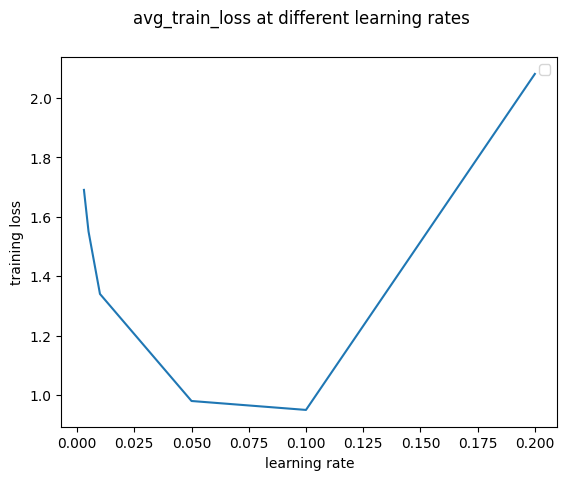

In [44]:
plt.figure()
plt.ylabel('training loss')
plt.xlabel('learning rate')
plt.plot(lrs, all_losses)
plt.legend()
plt.suptitle('avg_train_loss at different learning rates')
plt.show()

In [49]:
all_val_losses

[1.1597808442790605,
 1.0205468240900275,
 0.982734974024675,
 0.9497345459853306,
 0.9531865119805055,
 0.9671581272290779,
 0.9418463949504399,
 0.9530757723007967,
 0.9490781172557151,
 0.9989810051599021]

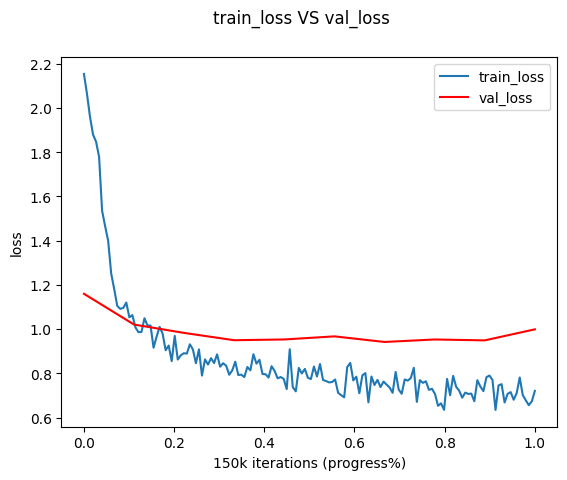

In [68]:
  fig, ax = plt.subplots()
  plt.ylabel('loss')
  plt.xlabel('150k iterations (progress%)')
  x1 = np.linspace(0, 1, 150)
  x2 = np.linspace(0, 1, 10)
  ax.plot(x1, all_train_losses, label='train_loss')
  ax.plot(x2, all_val_losses, color="red", label='val_loss')

  plt.legend()
  plt.suptitle('train_loss VS val_loss')
  fig.show()

In [ ]:
# Todo: Load saved model for testing
n_hidden = 128
output_size = n_categories
input_size = n_letters

test_model = CharRNNClassify(input_size, n_hidden, output_size)
test_model.load_state_dict(torch.load('model_classify_128_0.005_200000'))


<All keys matched successfully>

In [ ]:
# Todo: Load saved model for testing
n_hidden = 128
output_size = n_categories
input_size = n_letters

test_model = CharRNNClassify(input_size, n_hidden, output_size)
test_model.load_state_dict(torch.load('model_classify_128_0.005_200000'))

<All keys matched successfully>

In [ ]:
# PennGrader - DO NOT CHANGE
before = list(test_model.parameters())[-1].clone()
trainOneEpoch(test_model, nn.NLLLoss(),
              torch.optim.SGD(test_model.parameters(), lr=0.2),
              trainData[0], trainData[1])
after = list(test_model.parameters())[-1].clone()

grader.grade(test_case_id = 'testModelTrain', answer = (before.data.numpy(), after.data.numpy()))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

'''
Use this to plot confusion matrix for each model and save the plot.
'''
def confusion_matrix(model_name, data, n_hidden):

  test_model = CharRNNClassify(input_size, n_hidden, output_size)
  test_model.load_state_dict(torch.load(model_name))

  # Keep track of correct guesses in a confusion matrix
  confusion = torch.zeros(n_categories, n_categories)
  n_confusion = 10000

  # Go through a bunch of examples and record which are correctly guessed
  for i in range(n_confusion):
      category, line, category_tensor, line_tensor = random_training_pair(data[0], data[1])
      output, hidden = evaluate(test_model, line_tensor)
      guess, guess_i = category_from_output(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Set up plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)

  # Set up axes
  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  # lst = model_name.split('_')
  # fig_name = 'cm_' + lst[0] + '_' + lst[1] + '_' + lst[4] + '_'+ lst[5][-1:] + '_' + lst[6] + '.jpg'
  # plt.savefig(fig_name)
  plt.show()

<ipython-input-31-d5013c548b1f>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-31-d5013c548b1f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


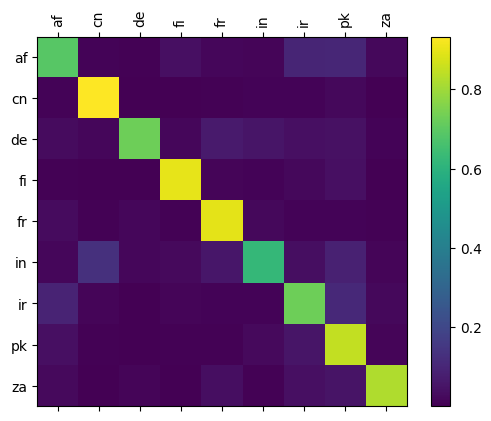

In [47]:
# Todo: Load saved model for testing
n_hidden = 128
output_size = n_categories
input_size = n_letters
confusion_matrix('bLSTM_model_classify_128_0.1_300000', trainData, n_hidden)


##**Experimentation and Analysis**

Complete the following analysis on the city names dataset, and include your finding in the report.

### **Task 1.5**
Write code to output accuracy on the validation set. Include your best accuracy in the report. (For a benchmark, the TAs were able to get accuracy above 50% without any hyperparameter optimization) Discuss where your model is making mistakes. Use a confusion matrix plot to support your answer.

In [48]:
# Todo: Load saved model
model_name = 'bLSTM_model_classify_128_0.1_300000'
test_model = CharRNNClassify(input_size, 128, output_size)
test_model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [36]:
# TODO: Read validation dataset
X_val, y_val = readData(train=False)
X_val_lst = X_val.tolist()
y_val_lst = y_val.tolist()

In [49]:
# Todo: Compute Validation accuracy
val_acc = calculateAccuracy(test_model, X_val_lst, y_val_lst)
val_acc

0.6844444444444444

In [ ]:
# PennGrader - DO NOT CHANGE
grader.grade(test_case_id = 'testValidation', answer = val_acc)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **Task 1.6**
Periodically compute the loss on the validation set, and create a plot with the training and validation loss as training progresses. Is your model overfitting? Include the plot in your report.

In [ ]:
# TODO: plot training and validation loss


### **Task 1.7**
Experiment with the learning rate. You can try a few different learning rates and observe how this affects the loss. Another common practice is to drop the learning rate when the loss has plateaued. Use plots to explain your experiments and their effects on the loss.

In [ ]:
# TODO: Use plots to explain your experiments and their effects on the loss.


###  **Task 1.8**
Experiment with the size of the hidden layer or the model architecture How does this affect validation accuracy?

## **Leaderboard**

Write code to make predictions on the provided test set. The test set has one unlabeled city name per line. Your code should output a file `labels.txt` with one two-letter country code per line. Make sure your test accuracy can pass the auto-grader and then experiment to achieve higher values. Extra credit will be given to the top 5 leaderboard submissions. Here are some ideas for improving your leaderboard performance:

 - Try dropout if your model is overfitting
 - Experiment with different loss functions, optimizers
 - Test out label smoothing
 - Compare the different types of RNNs - RNN, LSTM, GRU units.
 - Use a different initalization for the weights, for example, small random values instead of 0s

In your report, describe your final model and training parameters.

## **Bookkeeping**

Another tip for experimenting with neural network hyperparameters is to maintain notes (e.g. a spreadsheet or text-file) with different parameters and their resulting accuray. As you can imagine, there is a combinatorial explosion of the possible hyperparameter space so navigating it efficiently is best done by remembering your past experiments. Feel free to include this in your report as well.

### **Task 1.9**: Make predictions on the test set

In [38]:
# Helper function to load test set
def loadTest(filePath, label=False):
  arr = []
  with codecs.open(filePath, "r",encoding='utf-8', errors='ignore') as fp:
    if not label:
      for line in fp:
          arr.append(line.rstrip("\n"))
    else:
      for line in fp:
        arr.append(int(languages.index(line.rstrip("\n"))))
  return np.array(arr)

# Test set
cities_test = loadTest("./cities_test.txt")

In [39]:
len(cities_test)

900

In [50]:
# TODO: Load your model here and make predictions
model_name = 'bLSTM_model_classify_128_0.1_300000'
test_model = CharRNNClassify(input_size, 128, output_size)
test_model.load_state_dict(torch.load(model_name))

preds = predict(test_model, cities_test)

In [80]:
all_categories[preds[0]]

'pk'

In [51]:
# TODO: Save predictions as "labels.txt" with one two-letter country code per line.
with open('labels.txt', 'w') as f:
    for pred in preds:
        f.write(f"{all_categories[pred]}\n")

In [82]:
# PennGrader - DO NOT CHANGE
labels = loadTest("./labels.txt", True)
grader.grade(test_case_id = 'testTestSet', answer = labels)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 2: Text Generation

In this section, you will be following more PyTorch tutorial code in order to reproduce Karpathy’s text generation results. Read through the tutorial [here](http://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) to get an understanding for the neural architecture, and then download [this iPython notebook](https://github.com/spro/practical-pytorch/tree/master/char-rnn-generation) to base your own code on (it’s a bit easier to follow than the former).

You will notice that the code is quite similar to that of the classification problem. The biggest difference is in the loss function. For classification, we run the entire sequence through the RNN and then impose a loss only on the final class prediction. For the text generation task, we impose a loss at each step of the RNN on the predicted character. The classes in this second task are the possible characters to predict.

## **Experimenting with your own dataset**

Be creative! Pick some dataset that interests you. Here are some ideas:

 - [ABC music format](https://raw.githubusercontent.com/rdeese/tunearch-corpus/master/all-abcs.txt)
 - [Donald Trump speeches](https://github.com/ryanmcdermott/trump-speeches)
 - [Webster dictionary](http://www.gutenberg.org/cache/epub/29765/pg29765.txt)
 - [Jane Austen novels](http://www.gutenberg.org/files/31100/31100.txt)

Potential extra credit will be given for creative and impressive methods of curating a text dataset for generation!

### **Task 2.1**: Follow Karpathy's text generation and Experiment with your own dataset

### **Task 2.2**

In your report, include a sample of the text generated by your model, and give a qualitative discussion of the results. Where does it do well? Where does it seem to fail? Report perplexity on a couple validation texts that are similar and different to the training data. Compare your model’s results to that of an n-gram language model.

# Submission
### Congratulation on finishing your homework! Here are the deliverables you need to submit to GradeScope:

  - writeup.pdf: including Task 1.5, 1.6, 1.7, 1.8, 1.9, 2.2
  - This .ipynb notebook
  - `labels.txt` - predictions for leaderboard.